In [1]:
using Test

using LinearAlgebra: Diagonal, tr

using Keldysh; kd = Keldysh;
using KeldyshED; ked = KeldyshED; op = KeldyshED.Operators;

using QInchworm.ppgf: atomic_ppgf, operator_product
#using QInchworm.ppgf: total_density_operator, operator_matrix_representation
using QInchworm.ppgf: first_order_spgf

┌ Info: Precompiling KeldyshED [675b6b9c-7c2f-11e9-3bf3-dfd4d61640f7]
└ @ Base loading.jl:1278
┌ Warning: Package KeldyshED does not have Keldysh in its dependencies:
│ - If you have KeldyshED checked out for development and have
│   added Keldysh as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with KeldyshED
└ Loading Keldysh into KeldyshED from project dependency, future warnings for KeldyshED are suppressed.
┌ Info: Precompiling QInchworm [c1b6c5a0-2f71-4f50-a75d-692762eff855]
└ @ Base loading.jl:1278


In [2]:
β = 1.
μ = -0.5

H = μ * op.n("0")    
soi = ked.Hilbert.SetOfIndices([["0"]]);
ed = ked.EDCore(H, soi)
    
ρ = ked.density_matrix(ed, β)
    
# Real-time Kadanoff-Baym contour
    
contour = kd.twist(kd.Contour(kd.full_contour, tmax=7., β=β));
grid = kd.TimeGrid(contour, npts_real=20, npts_imag=10);
    
# Single particle Green's function
    
oidx = KeldyshED.Hilbert.IndicesType(["0"])
    
g = KeldyshED.computegf(ed, grid, [(oidx, oidx)], β)[1];
G0 = atomic_ppgf(grid, ed, β);

g_ref = first_order_spgf(G0, ed, oidx, oidx)
@test isapprox(g, g_ref, atol=1e-12, rtol=1-12)


Test Passed

# Visualization

In [4]:
using PyCall; PyCall.pygui(:tk);
using PyPlot; const plt = PyPlot; plt.pygui(false); plt.svg(true);

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/hugstr/.julia/packages/PyPlot/XHEG0/src/init.jl:192


In [5]:
extent = nothing
function plot2d(data; extent = nothing)
  # Correct for Row major order in Julia vs Column major in Python
  #data = transpose(data) # too clever, the arrays are sent as correct row/col major to matplotlib
  opt = Dict(:cmap=>"RdBu_r", :vmin=>-1., :vmax=>1., :origin=>"upper", :extent=>extent)
  plt.figure(figsize=(8, 3))
  plt.subplot(1, 2, 1)
  plt.imshow(real(data); opt...)
  plt.colorbar()
  plt.subplot(1, 2, 2)
  plt.imshow(imag(data); opt...)
  plt.colorbar()
  plt.tight_layout()
  return
end;

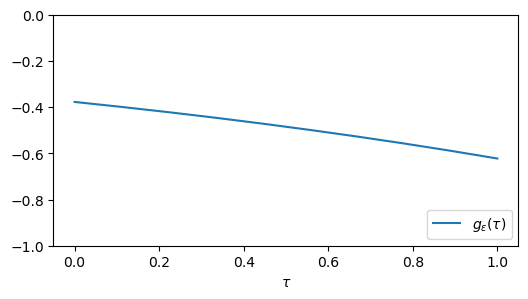

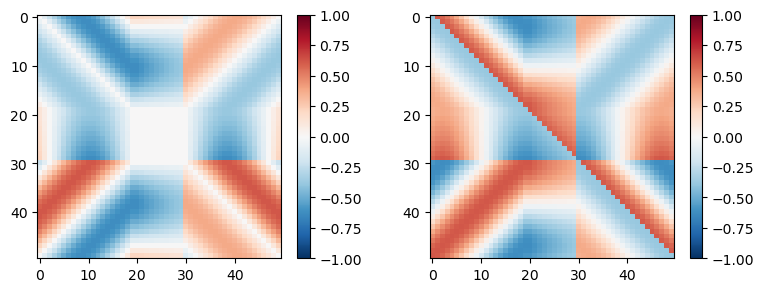

In [6]:
τ = kd.imagtimes(grid)
plt.figure(figsize=(6, 3))
plt.plot(τ, g[:matsubara], label=plt.L"$g_\varepsilon(\tau)$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); plt.ylim([-1., 0]);

plot2d(g.data)

In [7]:
ed

Dimension of full Hilbert space: 2
Number of invariant subspaces: 2
  Subspace 1, dim = 1
    Basis Fock states: UInt64[0x0000000000000001]
    Energy levels: [0.0]
  Subspace 2, dim = 1
    Basis Fock states: UInt64[0x0000000000000000]
    Energy levels: [0.5]
Ground state energy: -0.5


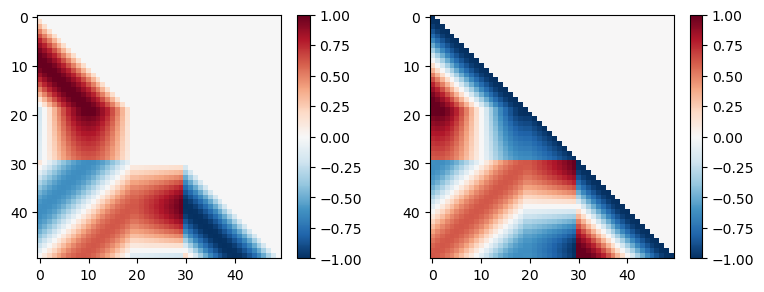

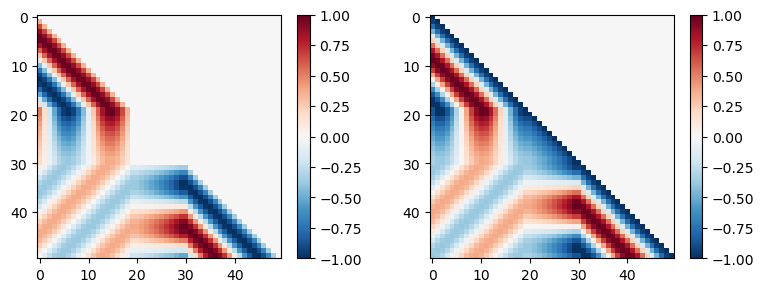

In [8]:
plot2d(G0[1].data[1, 1, :, :])
plot2d(G0[2].data[1, 1, :, :])

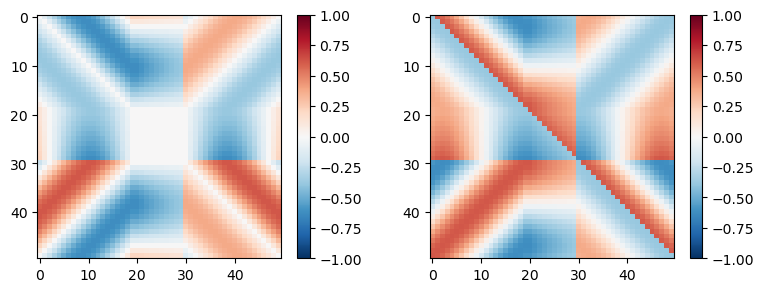

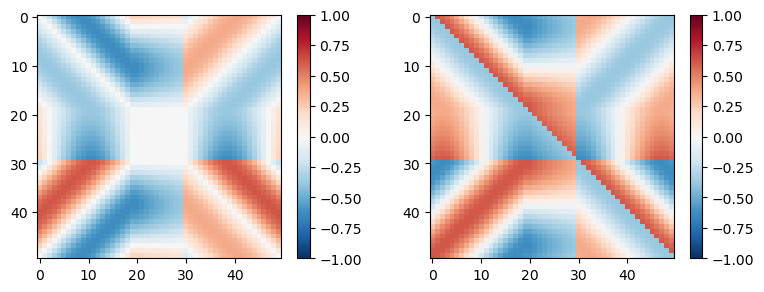

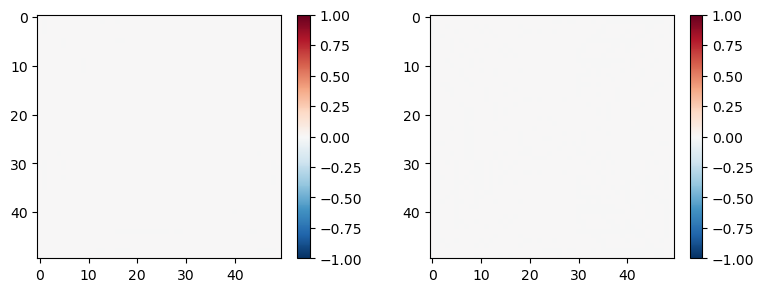

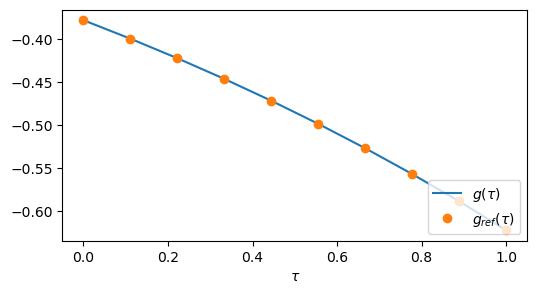

In [9]:
plot2d(g.data)
plot2d(g_ref.data)

plot2d(g.data - g_ref.data)

τ = kd.imagtimes(grid)
plt.figure(figsize=(6, 3))
plt.plot(τ, real(g[:matsubara]), label=plt.L"$g(\tau)$")
plt.plot(τ, real(g_ref[:matsubara]), "o", label=plt.L"$g_{ref}(\tau)$")
plt.xlabel(plt.L"$\tau$");
plt.legend(loc="lower right"); #plt.ylim([-1., 0]);
